## Setup

In [ ]:
#| code-fold: true
#| code-summary: "Show pip installs"
!pip install torch==2.3.1 -qq
!pip install accelerate==0.31.0 -qq
!pip install transformers==4.41.2 -qq
!pip install huggingface_hub -qq
!pip install datasets~=2.16.1 -qq
!pip install plotly==5.19.0 -qq
!pip install scikit-learn==1.2 -qq
!pip install pynvml -qq

In [ ]:
#| code-fold: true
#| code-summary: "Show imports and setup"
import gc
import pandas as pd
import numpy as np
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import torch

def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()
    
import warnings
#warnings.filterwarnings("ignore")

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import time

from datasets import load_dataset, Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline 
from transformers.pipelines.pt_utils import KeyDataset
from fastcore.all import *

#torch.set_default_device("cuda")
torch.cuda.set_device(0)

model_nm = "microsoft/Phi-3.5-mini-instruct"
model = AutoModelForCausalLM.from_pretrained( 
    model_nm,  
    device_map="cuda",  
    torch_dtype="auto",  
    trust_remote_code=True,  
) 

tokenizer = AutoTokenizer.from_pretrained(model_nm)

pipe = pipeline( 
    "text-generation", 
    model=model, 
    tokenizer=tokenizer, 
) 

# load dataset
dataset = load_dataset(
    "financial_phrasebank", "sentences_allagree", 
    split="train"  # note that the dataset does not have a default test split
)

In [ ]:
# create a new column with the numeric label verbalised as label_text (e.g. "positive" instead of "0")
label_map = {i: label_text for i, label_text in enumerate(dataset.features["label"].names)}

def add_label_text(example):
    example["label_text"] = label_map[example["label"]]
    return example

dataset = dataset.map(add_label_text)

print(dataset)

In [5]:
#| code-fold: true
#| code-summary: "Show `add_prompt` and `generate_responses` functions"
def add_prompt(item, prompt):
        item['prompt'] = prompt.format(text=item['sentence'])
        return item
    
def generate_responses(dataset, prompt):
    responses = []
    dataset = dataset.map(add_prompt, fn_kwargs={"prompt": prompt})
    
    # check that the prompt is correctly formatted
    print(dataset[0]['prompt'])
    print('---------')
    
    for row in dataset:
        messages = [  
            {"role": "user", "content": row['prompt']},
        ] 

        generation_args = { 
            "max_new_tokens": 2, 
            "return_full_text": False, 
            "temperature": 0.1, 
            "do_sample": True, 
        } 

        response = pipe(messages, **generation_args) 
        responses.append(response[0]['generated_text'].strip().lower())
        
    # calculate accuracy
    df = dataset.to_pandas()
    df['responses'] = pd.Series(responses)
    df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
    df['lm_match'] = df['label_text'] == df['responses']
    acc = df.lm_match.mean()
    return df, acc

In [6]:
#| code-fold: true
#| code-summary: "Show `generate_response` function"
def generate_response(prompt):
    messages = [  
        {"role": "user", "content": prompt},
    ] 

    generation_args = { 
        "max_new_tokens": 2, 
        "return_full_text": False, 
        "temperature": 0.1, 
        "do_sample": True, 
    } 

    output = pipe(messages, **generation_args) 
    return output[0]['generated_text']

In [7]:
#| code-fold: true
#| code-summary: "Show `make_cm` function"
def make_cm(df):
    """Create confusion matrix for true vs predicted sentiment classes"""
    
    cm = confusion_matrix(y_true=df['label_text'], y_pred=df['responses'], labels=['negative', 'neutral', 'positive', 'other'])
    disp = ConfusionMatrixDisplay(cm, display_labels=['negative', 'neutral', 'positive', 'other'])
    
    # I chose 8x8 so it fits on one screen but still is large
    fig, ax = plt.subplots(figsize=(8,8))
    disp.plot(ax=ax,text_kw={'fontsize': 16}, cmap='Blues', colorbar=False);
    
    # change label font size without changing label text
    ax.xaxis.label.set_fontsize(18)
    ax.yaxis.label.set_fontsize(18)
    
    # make tick labels larger
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)

In [8]:
#| code-fold: true
#| code-summary: "Show `ds_subset` function"
def ds_subset(dataset, exclude_idxs, columns=[0, 1, 2]):
    idxs = list(range(len(dataset)))
    idxs = [x for x in idxs if x not in exclude_idxs]
    ddf = dataset.to_pandas()
    new_ds = Dataset.from_pandas(ddf.iloc[idxs, columns])
    return new_ds

## Background

In this notebook I'll use [Phi-3-5-mini-4k-instruct](https://huggingface.co/microsoft/Phi-3.5-mini-instruct) to classify sentiment in the [`financial_phrasebank` dataset](https://huggingface.co/datasets/financial_phrasebank).
In previous notebooks I have performed [sentiment classification with phi-2](https://vishalbakshi.github.io/blog/posts/2024-08-31-tinysentiment-phi-2-sentiment-classification/) and [the Claude series](https://vishalbakshi.github.io/blog/posts/2024-08-29-tinysentiment-claude-experiments/).

This notebook is part of [a series of blog posts](https://vishalbakshi.github.io/blog/#category=TinySentiment) for a project I’m working called TinySentiment where I’m experimenting with tiny models to improve their ability to classify sentiment in the `financial_phrasebank dataset`. I was inspired to do so after reading [this blog post](https://huggingface.co/blog/synthetic-data-save-costs) and [this corresponding notebook](https://github.com/MoritzLaurer/synthetic-data-blog/blob/main/notebooks/synthetic_data_creation.ipynb) by Moritz Laurer as part of a fastai study group last year.

Here are the results from my experiments so far (\**the best-performing prompt from this notebook):

|Model|Prompting Strategy|Overall Accuracy|`negative`|`neutral`|`positive`|
|:-:|:-:|:-:|:-:|:-:|:-:|
|claude-3-5-sonnet-20240620|3-Shot|94.78%|98% (297/303) | 94% (1302/1391)|95% (544/570)|
|claude-3-opus-20240229|0-Shot|94.13%|98% (297/303)|96% (1333/1391)|88% (501/570)|
|\**phi-3.5|20-Shot|93.94%|96% (286/299)|98% (1355/1379)|83% (467/566)|
|ph-3|30-Shot w/System Prompt|92.79%|98% (290/297)|94% (1284/1373)|88% (499/564)|
|claude-3-haiku-20240307|3-Shot|92.39%|90% (272/303)|91% (1267/1391)|96% (550/570)|
|phi-2|6-Shot|91.94%|88% (267/302)|94% (1299/1387)|90% (510/569)|


Here are the per-prompt results from this notebook (phi-3.5):

|prompt|strategy|accuracy|negative|neutral|positive|
|:-:|:-:|:-:|:-:|:-:|:-:|
|[A](#prompt-A)|0-Shot|62.32%|98% (296/303)|43% (592/1391)|92% (523/570)|
|[B](#prompt-B)|0-Shot|88.60%|96% (290/303)|87% (1215/1391)|88% (501/570)|
|[C](#prompt-C)|0-Shot|83.48%|98% (298/303)|76% (1062/1391)|93% (530/570)|
|[D](#prompt-D)|0-Shot|68.64%|99% (300/303)|51% (713/1391)|95% (541/570)|
|[E](#prompt-E)|0-Shot|88.25%|96% (290/303)|87% (1207/1391)|88% (501/570)|
|[F](#prompt-F)|3-Shot|84.65%|98% (296/302)|77% (1070/1390)|96% (548/569)|
|[G](#prompt-G)|6-Shot|77.99%|98% (297/302)|66% (913/1387)|97% (551/569)|
|[H](#prompt-H)|3-Shot|83.06%|98% (296/302)|74% (1028/1390)|97% (554/569)|
|[I](#prompt-I)|3-Shot|51.61%|<u>**100% (302/302)**</u>|32% (447/1390)|73% (418/569)|
|[J](#prompt-J)|3-Shot|85.94%|98% (296/302)|80% (1108/1390)|95% (539/569)|
|[K](#prompt-K)|0-Shot|77.96%|98% (298/303)|66% (919/1391)|96% (548/570)|
|[L](#prompt-L)|0-Shot|80.57%|98% (297/303)|70% (972/1391)|<u>**97% (555/570)**</u>|
|[M](#prompt-M)|0-Shot|91.30%|97% (294/303)|90% (1257/1391)|91% (516/570)|
|[N](#prompt-N)|0-Shot w/System Prompt|88.74%|97% (295/303)|85% (1184/1391)|93% (530/570)|
|[O](#prompt-O)|0-Shot w/System Prompt|87.10%|94% (285/303)|83% (1156/1391)|93% (531/570)|
|[P](#prompt-P)|0-Shot|92.23%|94% (285/303)|94% (1307/1391)|87% (496/570)|
|[Q](#prompt-Q)|0-Shot|79.37%|99% (300/303)|73% (1009/1391)|86% (488/570)|
|<u>**[R](#prompt-R)**</u>|<u>**20-Shot**</u>|<u>**93.94%**</u>|96% (286/299)|98% (1355/1379)|83% (467/566)|
|[S](#prompt-S)|28-Shot|93.25%|94% (281/298)|99% (1358/1373)|79% (446/565)|
|[T](#prompt-T)|20-Shot|84.54%|78% (232/299)|<u>**99.9% (1378/1379)**</u>|51% (287/566)|


## Prompt A

The HuggingFace model card for Phi-3-5 Mini-4K-Instruct says:

> Given the nature of the training data, 
the Phi-3.5-mini-instruct model is best suited for prompts using the chat format

So, the first prompt I'll try will be a simple instruction:



In [8]:
promptA = """Label the following TEXT with a single word: negative, positive, or neutral
TEXT: {text}"""

In [9]:
text = dataset[1]["sentence"]
text

"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m ."

In [11]:
formatted_prompt = promptA.format(text=text)
print(formatted_prompt)

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .


In [12]:
generate_response(formatted_prompt)

You are not running the flash-attention implementation, expect numerical differences.


' Negative'

In [13]:
%time generate_response(formatted_prompt)

CPU times: user 101 ms, sys: 9.29 ms, total: 111 ms
Wall time: 109 ms


' Negative'

In [14]:
%timeit -n 10 generate_response(formatted_prompt)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


91.9 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Good--at least it works! Although it looks like I'll have to strip the 
outputs of whitespace and convert them to lowercase. It takes about 0.1 seconds to generate
the response, so it should take about 4 minutes to run inference on the whole dataset.

In [15]:
df, acc = generate_responses(dataset, promptA)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
---------


In [16]:
acc

0.6232332155477032

In [22]:
df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")

In [23]:
df.to_csv('/notebooks/phi-3-5_A.csv', index=False)

This prompt struggled with the `neutral` sentiment, as 568/1391 were misclassified as something other than
`positive`, `neutral` or `negative`.

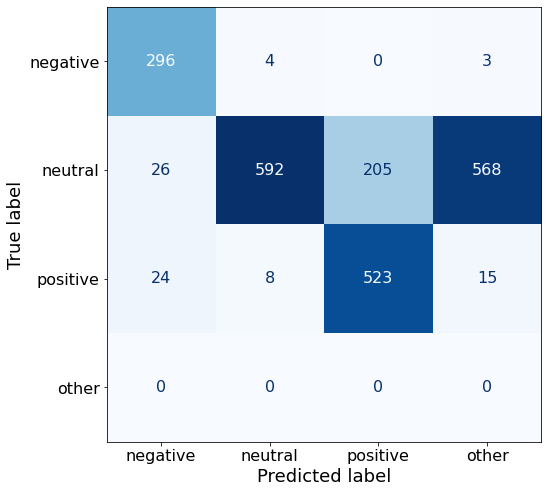

In [24]:
make_cm(df)

## Prompt B

I'll repeat the instruction after the sentence and see if that improves the performance (as it did for phi-2).

In [25]:
promptB = """Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: {text}
label the TEXT with a single word: negative, positive, or neutral"""

In [26]:
df, acc = generate_responses(dataset, promptB)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the TEXT with a single word: negative, positive, or neutral
---------


The accuracy jumps up from 62.3% to 88.6%! Repeating the instruction after the dataset item was something 
I learned to do in fastai study group.

In [27]:
acc

0.8860424028268551

In [28]:
df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")

In [29]:
df.to_csv('/notebooks/phi-3-5_B.csv', index=False)

The model does a much better job at predicting `neutral` sentiment with this adjustment.

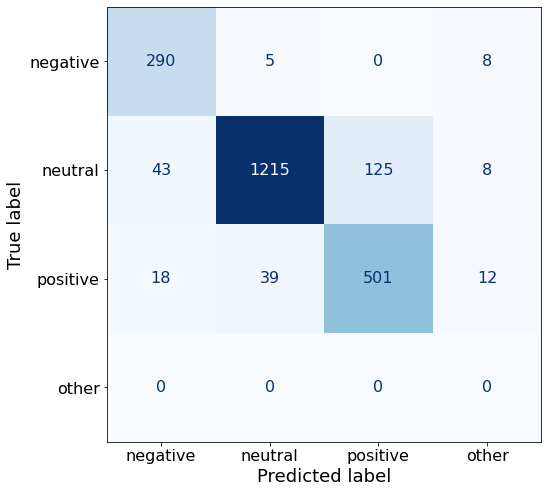

In [30]:
make_cm(df)

## Prompt C

I'll add some introductory text to the prompt to see if that improves the model's performance:

In [31]:
promptC = """Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: {text}
label the TEXT with a single word: negative, positive, or neutral"""

In [32]:
df, acc = generate_responses(dataset, promptC)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the TEXT with a single word: negative, positive, or neutral
---------


The addition of this introductory text actually worsens the model's performance by about 5%.

In [33]:
acc

0.8348056537102474

In [37]:
df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")

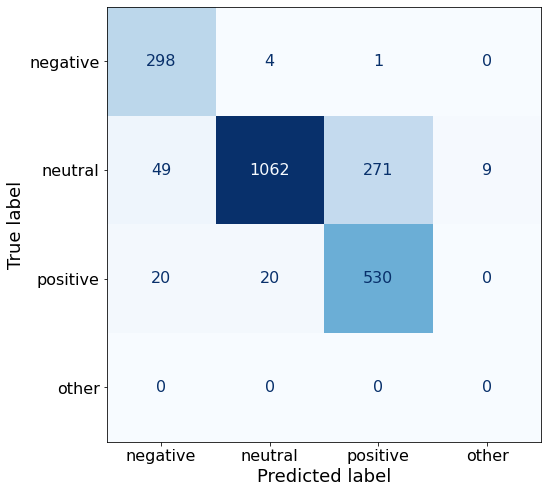

In [38]:
make_cm(df)

In [39]:
df.to_csv('/notebooks/phi-3-5_C.csv', index=False)

## Prompt D

I'll try another prompt language adjustment to Prompt B: I'll replace
"label" with "Respond".

In [43]:
promptD = """Instruct: Respond with only one of these words: negative, positive, or neutral
TEXT: {text}
Respond with only one of these words: negative, positive, or neutral"""

In [44]:
df, acc = generate_responses(dataset, promptD)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Instruct: Respond with only one of these words: negative, positive, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Respond with only one of these words: negative, positive, or neutral
---------


Wow! The accuracy plummets to 69%. This was something that had improved the accuracy for phi-2.

In [45]:
acc

0.6863957597173145

The model actually improves its performance on `negative` and `positive` sentences,
but significantly worsens its performance when classifying `neutral` sentences.

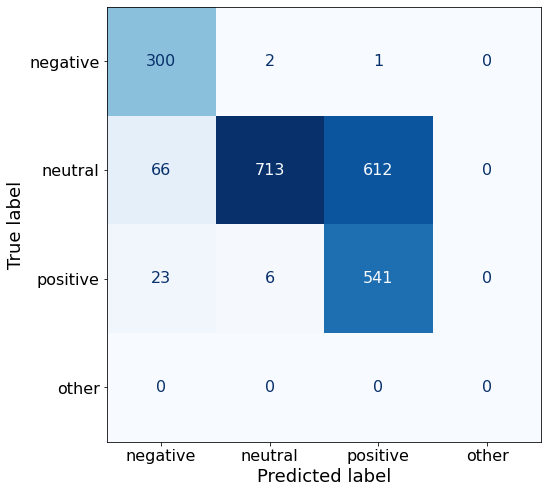

In [46]:
make_cm(df)

In [47]:
df.to_csv('/notebooks/phi-3-5_D.csv', index=False)

## Prompt E

Another adjustment that improved phi-2's performance was to add a period after the instruction. I'll see
if doing so improves phi-3.5's performance.

In [48]:
promptE = """Instruct: label the following TEXT with a single word: negative, positive, or neutral.
TEXT: {text}
label the TEXT with a single word: negative, positive, or neutral."""

In [49]:
df, acc = generate_responses(dataset, promptE)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Instruct: label the following TEXT with a single word: negative, positive, or neutral.
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the TEXT with a single word: negative, positive, or neutral.
---------


Interestingly, this actually worsens the overall accuracy a bit.

In [50]:
acc

0.8825088339222615

The `negative` and `positive` true positive rate is the same as Prompt B, but `neutral` rate is worse (1207 < 1215).

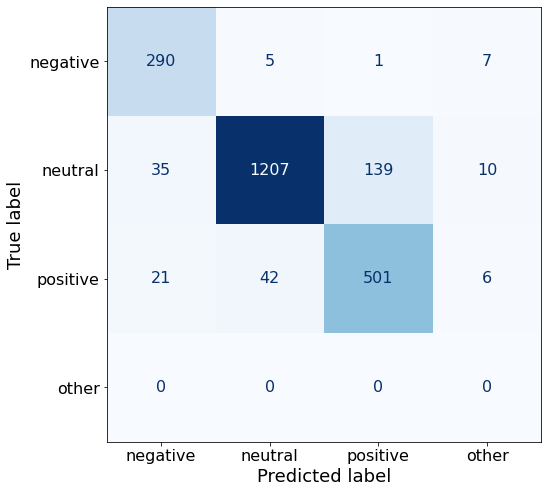

In [51]:
make_cm(df)

In [53]:
df.to_csv('/notebooks/phi-3-5_E.csv', index=False)

## Prompt F

I'll now move on to few-shot prompting to see if I can improve on the best overall accuracy so far (88.6%).
To do so, I'll create a new helper function (since the chat template handles few-shot prompt as multiple query-response exchanges between user and assistant).

In [8]:
#| code-fold: true
#| code-summary: "Show `few_shot_responses` function"
def few_shot_responses(dataset, prompt, examples):
    responses = []
    dataset = dataset.map(add_prompt, fn_kwargs={"prompt": prompt})

    few_shot_examples = []
    
    for example in examples:
        few_shot_examples.append({"role": "user", "content": prompt.format(text=example[0])})
        few_shot_examples.append({"role": "assistant", "content": example[1]})
    
    count = 0
    for row in dataset:
        count += 1
        messages = few_shot_examples + [{"role": "user", "content": row['prompt']}]
        
        if count == 1: print(messages)
        
        generation_args = { 
            "max_new_tokens": 2, 
            "return_full_text": False, 
            "temperature": 0.1, 
            "do_sample": True, 
        } 

        response = pipe(messages, **generation_args) 
        responses.append(response[0]['generated_text'].strip().lower())
        
    # calculate accuracy
    df = dataset.to_pandas()
    df['responses'] = pd.Series(responses)
    df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
    df['lm_match'] = df['label_text'] == df['responses']
    acc = df.lm_match.mean()
    return df, acc

In [74]:
exclude_idxs = [0, 1, 292]

In [75]:
promptF_ds = ds_subset(dataset, exclude_idxs)

In [76]:
promptF_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2261
})

In [77]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

examples

[('According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
  'neutral'),
 ("For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
  'positive'),
 ('Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .',
  'negative')]

In [82]:
df, acc = few_shot_responses(promptF_ds, promptB, examples)

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

[{'role': 'user', 'content': 'Instruct: label the following TEXT with a single word: negative, positive, or neutral\nTEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .\nlabel the TEXT with a single word: negative, positive, or neutral'}, {'role': 'assistant', 'content': 'neutral'}, {'role': 'user', 'content': "Instruct: label the following TEXT with a single word: negative, positive, or neutral\nTEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .\nlabel the TEXT with a single word: negative, positive, or neutral"}, {'role': 'assistant', 'content': 'positive'}, {'role': 'user', 'content': 'Instruct: label the following TEXT with a single word: negative, positive, or neutral\nTEXT: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a su

The accuracy drops to 84.65%.

In [83]:
acc

0.8465280849181778

Compared to Prompt B, the true positive rate for `neutral` decreases (1070 < 1215)
whereas for `positive` and `negative` sentiment the TPR increases (296 > 290, 548 > 501).

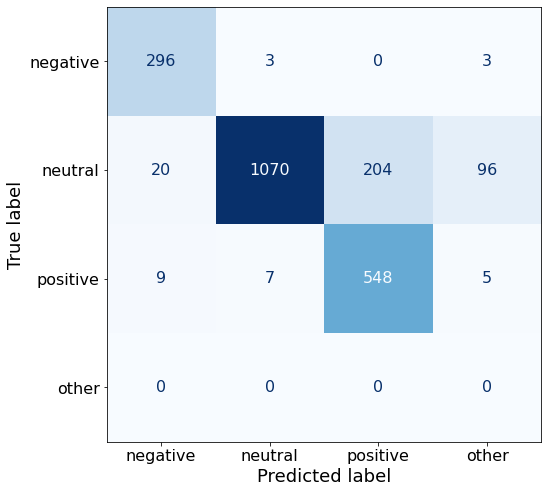

In [84]:
make_cm(df)

In [85]:
df.to_csv('/notebooks/phi-3-5_F.csv', index=False)

## Prompt G

I'll now try a 6-Shot prompt using the examples that were best-performing for phi-2.

In [86]:
exclude_idxs=[0, 1, 292, 37, 38, 39]
promptG_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)
promptG_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2258
})

In [88]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

examples[0], len(examples)

(('According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
  'neutral'),
 6)

In [89]:
df, acc = few_shot_responses(promptG_ds, promptB, examples)

Map:   0%|          | 0/2258 [00:00<?, ? examples/s]

[{'role': 'user', 'content': 'Instruct: label the following TEXT with a single word: negative, positive, or neutral\nTEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .\nlabel the TEXT with a single word: negative, positive, or neutral'}, {'role': 'assistant', 'content': 'neutral'}, {'role': 'user', 'content': "Instruct: label the following TEXT with a single word: negative, positive, or neutral\nTEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .\nlabel the TEXT with a single word: negative, positive, or neutral"}, {'role': 'assistant', 'content': 'positive'}, {'role': 'user', 'content': 'Instruct: label the following TEXT with a single word: negative, positive, or neutral\nTEXT: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a su

Unexpectedly, the accuracy drops to 78%.

In [90]:
acc

0.7798937112488928

The model performs better with this prompt than the so far best-performing 3-Shot prompt (84.7%) 
for `negative` sentences (297 > 296) and `positive` sentences (551 > 548) but performs much worse
for `neutral` sentences (913 < 1070).

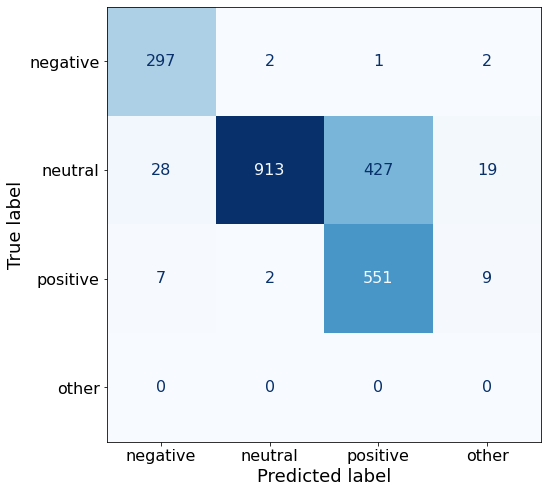

In [91]:
make_cm(df)

In [92]:
df.to_csv('/notebooks/phi-3-5_G.csv', index=False)

## Prompt H

I'll return to the 3-Shot prompt (84.65%) and see if I can improve it by adjusting the language.
First, I'll add some introductory text to the start of the prompt. Note that this did not improve the 0-Shot performance.

In [94]:
promptH = """Your task is to analyze the sentiment (from an investor's perspective) of the text below.
Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: {text}
label the TEXT with a single word: negative, positive, or neutral"""

In [95]:
exclude_idxs = [0, 1, 292]

examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

examples

[('According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
  'neutral'),
 ("For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
  'positive'),
 ('Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .',
  'negative')]

In [96]:
promptF_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2261
})

In [97]:
df, acc = few_shot_responses(promptF_ds, promptH, examples)

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

[{'role': 'user', 'content': "Your task is to analyze the sentiment (from an investor's perspective) of the text below.\nInstruct: label the following TEXT with a single word: negative, positive, or neutral\nTEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .\nlabel the TEXT with a single word: negative, positive, or neutral"}, {'role': 'assistant', 'content': 'neutral'}, {'role': 'user', 'content': "Your task is to analyze the sentiment (from an investor's perspective) of the text below.\nInstruct: label the following TEXT with a single word: negative, positive, or neutral\nTEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .\nlabel the TEXT with a single word: negative, positive, or neutral"}, {'role': 'assistant', 'content': 'positive'}, {'role': 'user', 'co

This does not improve the overall accuracy. Instead, it drops by about 1.6%.

In [98]:
acc

0.8306059265811587

Compared to the 3-Shot prompt, `negative` sentences are classified at the same frequency (296/302),
`neutral` sentences at a lower rate (1028 < 1070) and `positive` sentences at a higher rate (554 > 548).

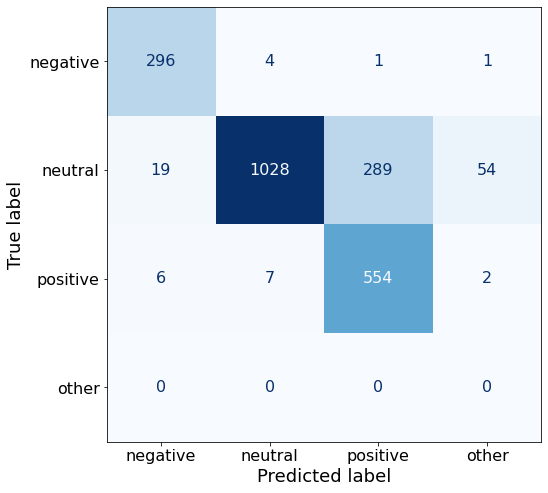

In [99]:
make_cm(df)

In [101]:
df.to_csv('/notebooks/phi-3-5_H.csv', index=False)

## Prompt I

Before I give the model more than 6 examples, I'll deviate from the recommended multi-turn chat format for few-shot
prompting and give the examples in a single prompt.

In [103]:
promptI = """Instruct: label the following TEXT with a single word: negative, positive, or neutral

Examples:

TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the TEXT with a single word: negative, positive, or neutral
neutral

TEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
label the TEXT with a single word: negative, positive, or neutral
positive

TEXT: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
label the TEXT with a single word: negative, positive, or neutral
negative

TEXT: {text}
label the TEXT with a single word: negative, positive, or neutral
"""

In [104]:
promptF_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2261
})

In [105]:
df, acc = generate_responses(promptF_ds, promptI)

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

Instruct: label the following TEXT with a single word: negative, positive, or neutral

Examples:

TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the TEXT with a single word: negative, positive, or neutral
neutral

TEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
label the TEXT with a single word: negative, positive, or neutral
positive

TEXT: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
label the TEXT with a single word: negative, positive, or neutral
negative

TEXT: In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .
label the TEXT with a single word: negative, positive, or neutral

---------


Nope! The performance of few-shot prompting without multi-turn format is drastically worse.

In [106]:
acc

0.5161432994250331

The true positive rate for `negative` sentiment is actually higher (302/302 or 100%) but the 
rate is much lower for `neutral` sentiment (917 < 1070) and `positive` sentiment (418 < 548).

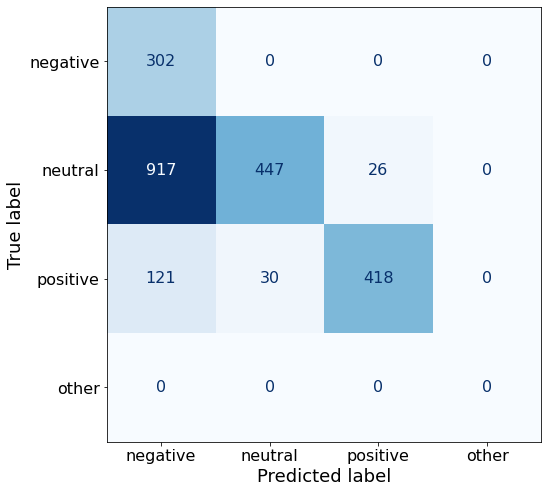

In [107]:
make_cm(df)

In [108]:
df.to_csv('/notebooks/phi-3-5_I.csv', index=False)

## Prompt J

I'll try one more prompt with single-turn few-shot examples. I'll add "Output:" before the label in each example, 
and add the "Instruct:" instructions before each example TEXT. I'll also remove the extra new line that I have
after the final instruction.

In [111]:
promptJ = """Instruct: label the following TEXT with a single word: negative, positive, or neutral

Examples:

Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the TEXT with a single word: negative, positive, or neutral
Output: neutral

Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
label the TEXT with a single word: negative, positive, or neutral
Output: positive

Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
label the TEXT with a single word: negative, positive, or neutral
Output: negative

Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: {text}
label the TEXT with a single word: negative, positive, or neutral
Output: """

In [112]:
df, acc = generate_responses(promptF_ds, promptJ)

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

Instruct: label the following TEXT with a single word: negative, positive, or neutral

Examples:

Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the TEXT with a single word: negative, positive, or neutral
Output: neutral

Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
label the TEXT with a single word: negative, positive, or neutral
Output: positive

Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
label the TEXT wi

Wow! This actually made a difference. This is the second-best overall accuracy I have achieved.

In [113]:
acc

0.8593542680229986

Compared to the previous second-best prompt (3-Shot), this prompt results in the same true positive rate
for `negative` sentiment (296/302), a much higher rate for `neutral` sentiment (1108 > 1070) and a 
lower rate for `positive` sentiment (539 < 548).

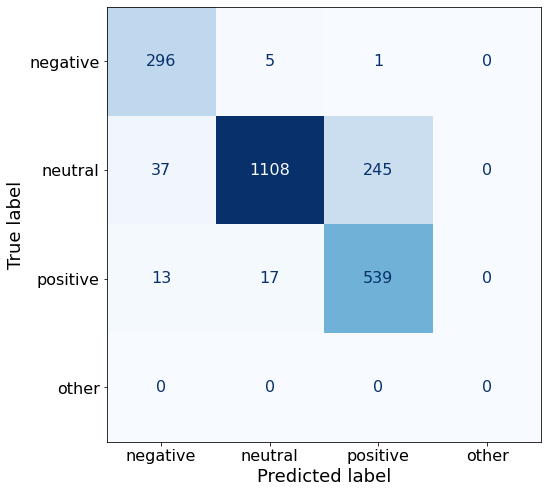

In [114]:
make_cm(df)

In [115]:
df.to_csv('/notebooks/phi-3-5_J.csv', index=False)

## Prompt K

I'll return to few-shot prompting in a bit, but want to first revisit zero-shot prompting as it yielded
the best overall performance so far (88.6% overall accuracy).

I asked Claude for suggestions on how to improve that prompt and will be trying them out.

First suggestion:

> Refine the Instruction: Try slight variations of the instruction to see if they yield better results:

In [117]:
promptK = """Instruct: Analyze the sentiment of the following financial statement and respond with a single word: negative, positive, or neutral
Financial statement: {text}
Sentiment (respond with a single word):"""

In [118]:
df, acc = generate_responses(dataset, promptK)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Instruct: Analyze the sentiment of the following financial statement and respond with a single word: negative, positive, or neutral
Financial statement: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Sentiment (respond with a single word):
---------


This yields a worse overall accuracy.

In [119]:
acc

0.7795936395759717

Compared to the best-performing 0-Shot Prompt B (88.6%) this prompt yields a higher true positive rate
for `neutral` sentiment (298 > 290) and `positive` sentiment (548 > 501) 
but lower for `neutral` sentiment (919 < 1215).

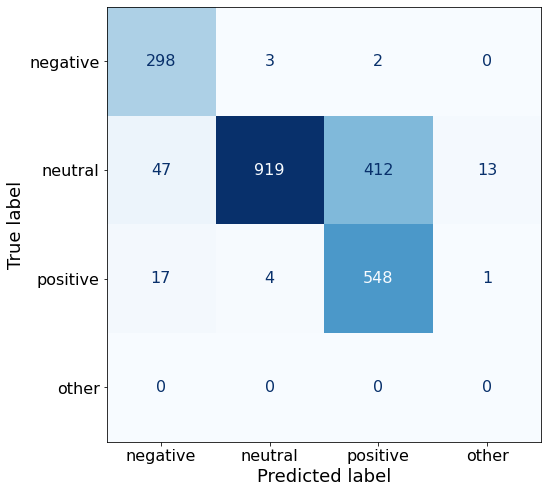

In [120]:
make_cm(df)

In [121]:
df.to_csv('/notebooks/phi-3-5_K.csv', index=False)

## Prompt L

Given the success of that prompt with `negative` and `positive` sentiment, I'll see if I can improve it for
`neutral` sentiment by adding the phrase: "if you’re not sure, respond with neutral."

In [122]:
promptL = """Instruct: Analyze the sentiment of the following financial statement and respond with a single word: negative, positive, or neutral. If you’re not sure, respond with neutral.
Financial statement: {text}
Sentiment (respond with a single word, if you’re not sure, respond with neutral):"""

In [123]:
df, acc = generate_responses(dataset, promptL)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Instruct: Analyze the sentiment of the following financial statement and respond with a single word: negative, positive, or neutral. If you’re not sure, respond with neutral.
Financial statement: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Sentiment (respond with a single word, if you’re not sure, respond with neutral):
---------


This improves the overall accuracy but is still lower than the Prompt B (88.6%).

In [124]:
acc

0.8056537102473498

Compared to Prompt K, the true positive rate for each sentiment increased.

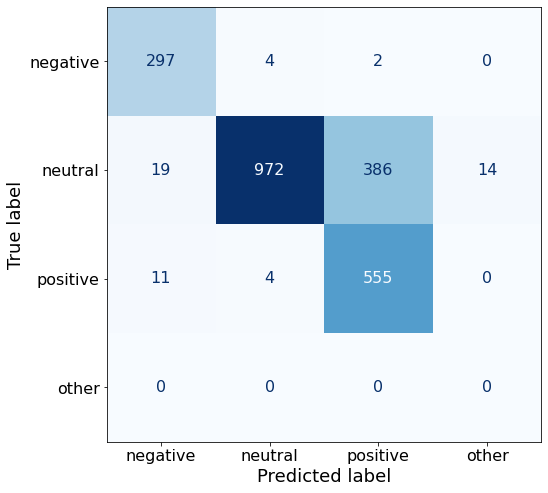

In [125]:
make_cm(df)

In [126]:
df.to_csv('/notebooks/phi-3-5_L.csv', index=False)

## Prompt M

Given the success of the phrase "if you're not sure, respond with neutral" I'll add it to Prompt B.

In [14]:
promptM = """Instruct: label the following TEXT with a single word: negative, positive, or neutral. If you're not sure, respond with neutral.
TEXT: {text}
label the TEXT with a single word: negative, positive, or neutral. If you're not sure, respond with neutral."""

In [130]:
df, acc = generate_responses(dataset, promptM)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Instruct: label the following TEXT with a single word: negative, positive, or neutral. If you're not sure, respond with neutral.
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the TEXT with a single word: negative, positive, or neutral. If you're not sure, respond with neutral.
---------


Hooray!! With this language adjustment, I have achieved the best overall accuracy so far.

In [131]:
acc

0.9129858657243817

The true positive rate for all three sentiments has increased.

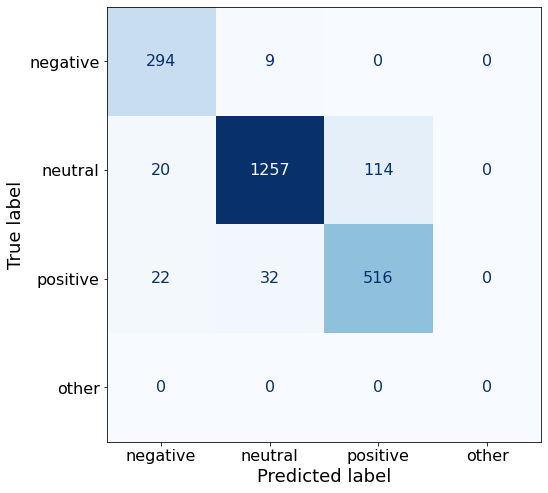

In [132]:
make_cm(df)

In [133]:
df.to_csv('/notebooks/phi-3-5_M.csv', index=False)

## Prompt N

I'll see if adding a system prompt improves the performance.

In [12]:
#| code-fold: true
#| code-summary: "Show updated `generate_responses` function"
def generate_responses(dataset, prompt, sp=False):
    responses = []
    dataset = dataset.map(add_prompt, fn_kwargs={"prompt": prompt})
    
    # check that the prompt is correctly formatted
    print(dataset[0]['prompt'])
    print('---------')
    
    for row in dataset:
        
        if sp:
            messages = [{'role': 'system', 'content': 'You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral. Consider the overall impact and implications of the statement when making your classification.'}
                       ] + [{"role": "user", "content": row['prompt']},]
            
        else: messages = [{"role": "user", "content": row['prompt']},] 

        generation_args = { 
            "max_new_tokens": 2, 
            "return_full_text": False, 
            "temperature": 0.1, 
            "do_sample": True, 
        } 

        response = pipe(messages, **generation_args) 
        responses.append(response[0]['generated_text'].strip().lower())
        
    # calculate accuracy
    df = dataset.to_pandas()
    df['responses'] = pd.Series(responses)
    df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
    df['lm_match'] = df['label_text'] == df['responses']
    acc = df.lm_match.mean()
    return df, acc

In [15]:
df, acc = generate_responses(dataset, promptM, sp=True)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Instruct: label the following TEXT with a single word: negative, positive, or neutral. If you're not sure, respond with neutral.
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the TEXT with a single word: negative, positive, or neutral. If you're not sure, respond with neutral.
---------


You are not running the flash-attention implementation, expect numerical differences.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Adding that system prompt results in a worse accuracy.

In [19]:
acc

0.8873674911660777

The true positive rate for `negative` (295 > 290) and `positive` (530 > 501) increases but 
for `neutral` (1184 < 1215) decreases.

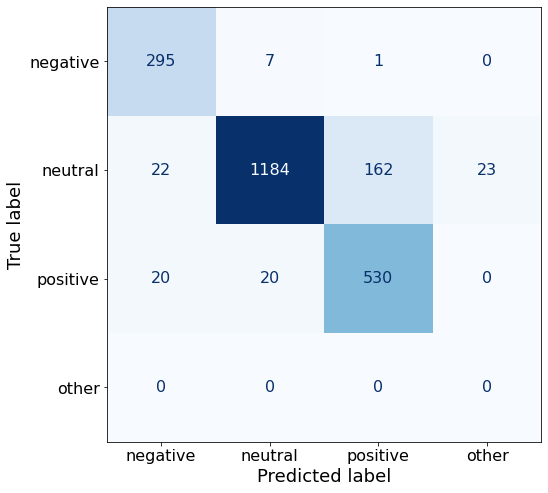

In [20]:
make_cm(df)

In [21]:
df.to_csv('/notebooks/phi-3-5_N.csv', index=False)

## Prompt O

I'll see if adding "if you're not sure, respond with neutral" to the system message improves performance.

In [7]:
#| code-fold: true
#| code-summary: "Show updated `generate_responses` function"
def generate_responses(dataset, prompt, sp=False):
    responses = []
    dataset = dataset.map(add_prompt, fn_kwargs={"prompt": prompt})
    
    # check that the prompt is correctly formatted
    print(dataset[0]['prompt'])
    print('---------')
    
    for row in dataset:
        
        if sp:
            messages = [{'role': 'system', 'content': sp}
                       ] + [{"role": "user", "content": row['prompt']},]
            
        else: messages = [{"role": "user", "content": row['prompt']},] 

        generation_args = { 
            "max_new_tokens": 2, 
            "return_full_text": False, 
            "temperature": 0.1, 
            "do_sample": True, 
        } 

        response = pipe(messages, **generation_args) 
        responses.append(response[0]['generated_text'].strip().lower())
        
    # calculate accuracy
    df = dataset.to_pandas()
    df['responses'] = pd.Series(responses)
    df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
    df['lm_match'] = df['label_text'] == df['responses']
    acc = df.lm_match.mean()
    return df, acc

In [36]:
sp = "You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral. Consider the overall impact and implications of the statement when making your classification. If you're not sure, respond with neutral."

In [37]:
print(sp)

You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral. Consider the overall impact and implications of the statement when making your classification. If you're not sure, respond with neutral.


In [38]:
df, acc = generate_responses(dataset, promptM, sp=sp)

Instruct: label the following TEXT with a single word: negative, positive, or neutral. If you're not sure, respond with neutral.
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the TEXT with a single word: negative, positive, or neutral. If you're not sure, respond with neutral.
---------


This system prompt still performs worse than no system prompt.

In [39]:
acc

0.8710247349823321

Compared to the best-performing Prompt M, this prompt yields a higher true positive rate 
for `positive` sentiment (531 > 501) but a lower rate for `neutral` sentiment (1156 < 1215) 
and for `negative` (294 > 290) sentiment.

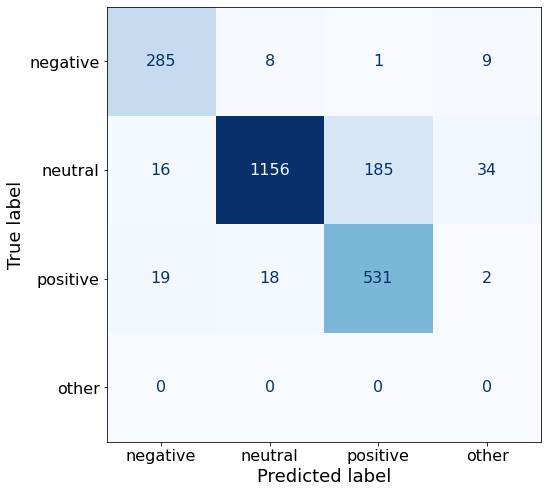

In [40]:
make_cm(df)

In [42]:
df.to_csv('/notebooks/phi-3-5_O.csv', index=False)

## Prompt P

I'll move away from system prompts for now and revisit language adjustments. For Prompt M, I'll replace:

>If you're not sure, respond with neutral.

with 

>If the amount of money is not explicitly increasing or decreasing, respond with neutral.

In [15]:
promptP = """Instruct: label the following TEXT with a single word: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
TEXT: {text}
label the TEXT with a single word: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral."""

In [31]:
df, acc = generate_responses(dataset, promptP)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Instruct: label the following TEXT with a single word: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the TEXT with a single word: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
---------


Excellent! The overall accuracy again increases, this time to 92.2%. 
I'm still quite surprised it's taken so much effort to surpass phi-2, but I'll reflect on that later on.

In [32]:
acc

0.9222614840989399

Both `negative` and `positive` sentiment true positive rates decrease, but this prompt results in almost 100
more correct `neutral` responses.

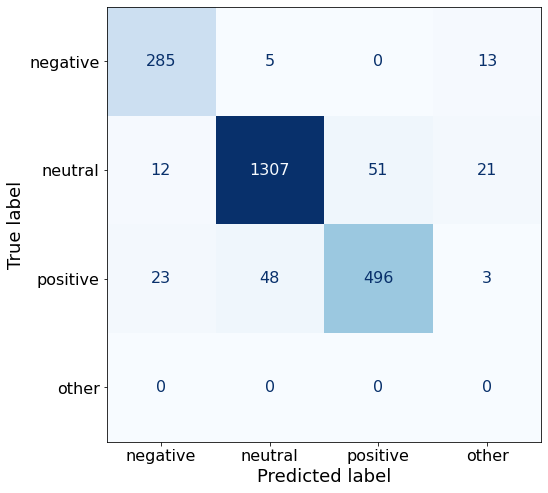

In [33]:
make_cm(df)

In [34]:
df.to_csv('/notebooks/phi-3-5_P.csv', index=False)

## Prompt Q

Given the success of the zero-shot prompt with instructions on handling neutral statements,
I'll try a prompt suggested by Claude, which adds more nuance to handling neutral 
sentences:

In [9]:
promptQ = """Instruct: label the following TEXT with a single word: negative, positive, or neutral. If the amount of money, market share, or key performance indicators are not explicitly increasing or decreasing, respond with neutral. 
TEXT: {text}
label the TEXT with a single word: negative, positive, or neutral. If key financial metrics are not clearly changing, respond with neutral. If the amount of money, market share, or key performance indicators are not explicitly increasing or decreasing, respond with neutral."""

In [10]:
print(promptQ)

Instruct: label the following TEXT with a single word: negative, positive, or neutral. If the amount of money, market share, or key performance indicators are not explicitly increasing or decreasing, respond with neutral. 
TEXT: {text}
label the TEXT with a single word: negative, positive, or neutral. If key financial metrics are not clearly changing, respond with neutral. If the amount of money, market share, or key performance indicators are not explicitly increasing or decreasing, respond with neutral.


In [11]:
df, acc = generate_responses(dataset, promptQ)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Instruct: label the following TEXT with a single word: negative, positive, or neutral. If the amount of money, market share, or key performance indicators are not explicitly increasing or decreasing, respond with neutral. 
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the TEXT with a single word: negative, positive, or neutral. If key financial metrics are not clearly changing, respond with neutral. If the amount of money, market share, or key performance indicators are not explicitly increasing or decreasing, respond with neutral.
---------


You are not running the flash-attention implementation, expect numerical differences.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


A more nuanced prompt actually deteriorates the overall accuracy by about 13%.

In [12]:
acc

0.7937279151943463

Compared to the best performing prompt P (92.2%), this prompt performs better on 
`negative` sentiment and worse on `neutral` and `positive` sentiment.

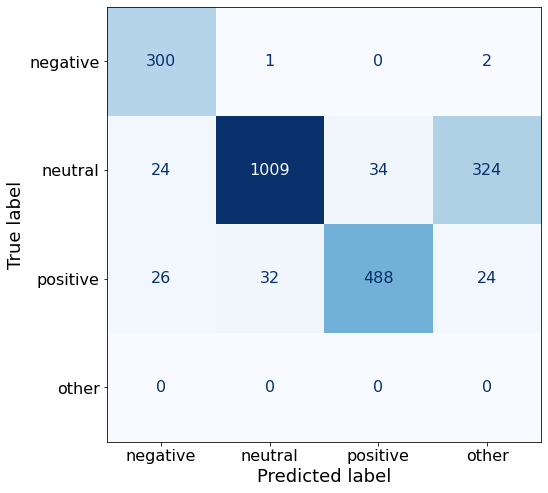

In [13]:
make_cm(df)

In [14]:
df.to_csv('/notebooks/phi-3-5_Q.csv', index=False)

## Prompt R

I'll now try providing a large number of examples (20) in the prompt. I don't expect
this to improve upon my 92.2% accuracy since 3-Shot and 6-Shot prompting performed worse.
Nevertheless, I've heard that it's not uncommon to give a model dozens of examples.

In [10]:
exclude_idxs = [1, 2, 3, 4, 292, 293, 294, 347, 0, 37, 38, 39, 40, 263, 264, 265, 266, 270, 274, 283]

In [11]:
promptR_ds = ds_subset(dataset, exclude_idxs=exclude_idxs, columns=[0, 1, 2])
promptR_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2244
})

In [19]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

examples[0], len(examples)

(("For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
  'positive'),
 20)

In [23]:
df, acc = few_shot_responses(promptR_ds, promptP, examples)

Map:   0%|          | 0/2244 [00:00<?, ? examples/s]

[{'role': 'user', 'content': "Instruct: label the following TEXT with a single word: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.\nTEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .\nlabel the TEXT with a single word: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral."}, {'role': 'assistant', 'content': 'positive'}, {'role': 'user', 'content': 'Instruct: label the following TEXT with a single word: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.\nTEXT: In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .\nlabel the TEXT with a single word: negative, pos

Wow! I'm so glad I tried a larger number of examples. The accuracy (93.94%) is now 
competitive with the Claude models!

In [24]:
acc

0.9393939393939394

With 20-Shot prompting, the true positive rate for `negative` (286 > 285) and `neutral` 
(1355 > 1307) sentiment increases, and decreases for `positive` (467 < 496) sentiment.

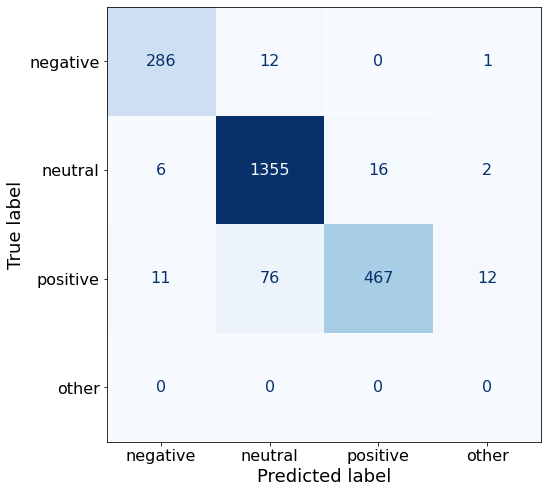

In [25]:
make_cm(df)

In [26]:
df.to_csv('/notebooks/phi-3-5_R.csv', index=False)

## Prompt S

I'll increase the number of examples to 28 and see if that yields an improvement.
I currently have 4 `positive`, 4 `negative` and 12 `neutral` examples.
I'll up that to 5:5:18.

In [11]:
exclude_idxs = [
    1, 2, 3, 4, 5, # positive
    292, 293, 294, 347, 348, # negative
    0, 37, 38, 39, 40, 263, 264, 265, 266, 270, 274, 283, 284, 285, 286, 287, 288, 289 # neutral
]

In [12]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

examples[0], len(examples)

(("For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
  'positive'),
 28)

In [13]:
promptS_ds = ds_subset(dataset, exclude_idxs=exclude_idxs, columns=[0, 1, 2])
promptS_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2236
})

In [16]:
df, acc = few_shot_responses(promptS_ds, promptP, examples)

Map:   0%|          | 0/2236 [00:00<?, ? examples/s]

[{'role': 'user', 'content': "Instruct: label the following TEXT with a single word: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.\nTEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .\nlabel the TEXT with a single word: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral."}, {'role': 'assistant', 'content': 'positive'}, {'role': 'user', 'content': 'Instruct: label the following TEXT with a single word: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.\nTEXT: In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .\nlabel the TEXT with a single word: negative, pos

You are not running the flash-attention implementation, expect numerical differences.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Interestingly, that decreases the overall accuracy by about 0.7%.

In [17]:
acc

0.932468694096601

Compared to Prompt R, this prompt yields fewer correct `negative` and `positive` sentences. It classifies 3 more `neutral` sentences correctly,
but that doesn't make up for the loss in performance of the other two sentiments.

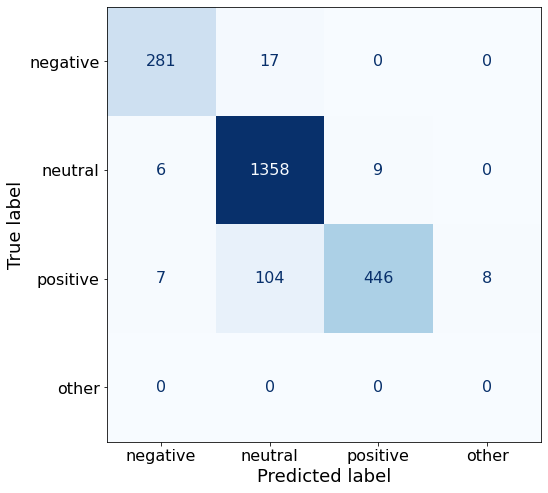

In [18]:
make_cm(df)

In [19]:
df.to_csv('/notebooks/phi-3-5_S.csv', index=False)

## Prompt T

I noticed in the Prompt R results that 14 sentences were classified as something "other" than `neutral`, `positive`, or `negative`. 
Instead of asking the model to respond with `negative`, `neutral` or `positive`, I'll ask it to respond with `0`, `1` or `2` and see if that simplification
yields better results.

In [12]:
promptT = """Instruct: label the following TEXT with a single integer: 0 (negative), 1 (neutral), or 2 (positive). If the amount of money is not explicitly increasing or decreasing, respond with 1 (neutral).
TEXT: {text}
label the TEXT with a single integer: 0 (negative), 1 (neutral), or 2 (positive). If the amount of money is not explicitly increasing or decreasing, respond with 1 (neutral)."""

In [13]:
print(promptT)

Instruct: label the following TEXT with a single integer: 0 (negative), 1 (neutral), or 2 (positive). If the amount of money is not explicitly increasing or decreasing, respond with 1 (neutral).
TEXT: {text}
label the TEXT with a single integer: 0 (negative), 1 (neutral), or 2 (positive). If the amount of money is not explicitly increasing or decreasing, respond with 1 (neutral).


In [14]:
exclude_idxs = [1, 2, 3, 4, 292, 293, 294, 347, 0, 37, 38, 39, 40, 263, 264, 265, 266, 270, 274, 283]

In [15]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], str(dataset[idx]['label'])))

examples[0], len(examples)

(("For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
  '2'),
 20)

In [17]:
#| code-fold: true
#| code-summary: "Show updated `few_shot_responses` function"
def few_shot_responses(dataset, prompt, examples):
    responses = []
    dataset = dataset.map(add_prompt, fn_kwargs={"prompt": prompt})

    few_shot_examples = []
    
    for example in examples:
        few_shot_examples.append({"role": "user", "content": prompt.format(text=example[0])})
        few_shot_examples.append({"role": "assistant", "content": example[1]})
    
    count = 0
    for row in dataset:
        count += 1
        messages = few_shot_examples + [{"role": "user", "content": row['prompt']}]
        
        if count == 1: print(messages)
        
        generation_args = { 
            "max_new_tokens": 2, 
            "return_full_text": False, 
            "temperature": 0.1, 
            "do_sample": True, 
        } 

        response = pipe(messages, **generation_args) 
        responses.append(response[0]['generated_text'].strip().lower())
        
    # calculate accuracy
    df = dataset.to_pandas()
    df['responses'] = pd.Series(responses)
    return df

In [18]:
df = few_shot_responses(promptR_ds, promptT, examples)

Map:   0%|          | 0/2244 [00:00<?, ? examples/s]

[{'role': 'user', 'content': "Instruct: label the following TEXT with a single integer: 0 (negative), 1 (neutral), or 2 (positive). If the amount of money is not explicitly increasing or decreasing, respond with 1 (neutral).\nTEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .\nlabel the TEXT with a single integer: 0 (negative), 1 (neutral), or 2 (positive). If the amount of money is not explicitly increasing or decreasing, respond with 1 (neutral)."}, {'role': 'assistant', 'content': '2'}, {'role': 'user', 'content': 'Instruct: label the following TEXT with a single integer: 0 (negative), 1 (neutral), or 2 (positive). If the amount of money is not explicitly increasing or decreasing, respond with 1 (neutral).\nTEXT: In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .

You are not running the flash-attention implementation, expect numerical differences.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [32]:
df['responses'] = df['responses'].apply(lambda x: dataset.features["label"].names[int(x)])
df['lm_match'] = df['label_text'] == df['responses']
acc = df['lm_match'].mean()

Interestingly, this decreases the overall accuracy by almost 10%.

In [33]:
acc

0.8453654188948306

While there are no `other` classifications, and `neutral` true positive rate increases (1378 > 1355), the rate for `negative` (232 < 286) and 
especially `positive` (287 < 467) sentiment decreases. The model classifies almost half of the `positive` sentences as `neutral`.

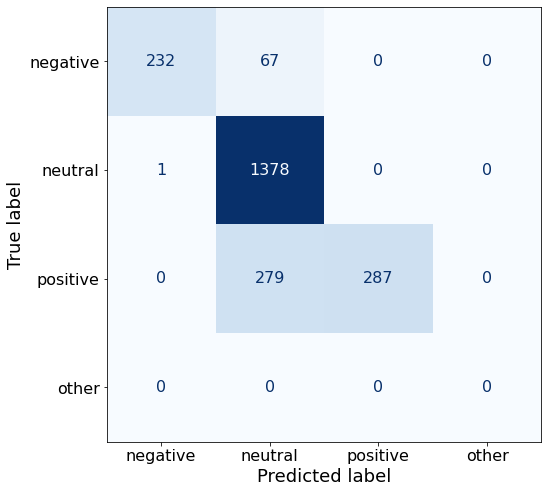

In [34]:
make_cm(df)

## Running Inference with the Best Prompt Multiple Times

For phi-2 I ran the best-performing prompt 10 times to see if it consistently performed at a high accuracy. Inference with phi-3.5, given the 20 examples 
in each prompt, takes much longer:

In [9]:
exclude_idxs = [1, 2, 3, 4, 292, 293, 294, 347, 0, 37, 38, 39, 40, 263, 264, 265, 266, 270, 274, 283]

In [10]:
promptR_ds = ds_subset(dataset, exclude_idxs=exclude_idxs, columns=[0, 1, 2])
promptR_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2244
})

In [11]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

len(examples)

20

In [12]:
promptP = """Instruct: label the following TEXT with a single word: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
TEXT: {text}
label the TEXT with a single word: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral."""

In [13]:
print(promptP)

Instruct: label the following TEXT with a single word: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
TEXT: {text}
label the TEXT with a single word: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.


In [41]:
#| code-fold: true
#| code-summary: "Show `test_gen` function"
def test_gen(examples):
    responses = []
    
    few_shot_examples = []
    
    for example in examples:
        few_shot_examples.append({"role": "user", "content": promptP.format(text=example[0])})
        few_shot_examples.append({"role": "assistant", "content": example[1]})
        
    messages = few_shot_examples + [{"role": "user", "content": promptP.format(text=dataset[0])}]


    generation_args = { 
        "max_new_tokens": 2, 
        "return_full_text": False, 
        "temperature": 0.1, 
        "do_sample": True, 
    } 

    response = pipe(messages, **generation_args) 
    responses.append(response[0]['generated_text'].strip().lower())
    return responses

The model takes about 1.2 seconds to generate a response for a single dataset item, or about 45 minutes for the 2244 items (on a Paperspace Free-A4000). 
Given the 6 hour limit, the max I can do is run inference on the dataset 8 times. To be conservative, I'll do it 7 times.

In [42]:
%timeit -n 10 test_gen(examples)

1.2 s ± 14.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
#| code-fold: true
#| code-summary: "Show `few_shot_responses` function"
def few_shot_responses(dataset, prompt, examples):
    responses = []
    dataset = dataset.map(add_prompt, fn_kwargs={"prompt": prompt})

    few_shot_examples = []
    
    for example in examples:
        few_shot_examples.append({"role": "user", "content": prompt.format(text=example[0])})
        few_shot_examples.append({"role": "assistant", "content": example[1]})
    
    for row in dataset:
        messages = few_shot_examples + [{"role": "user", "content": row['prompt']}]
        
        generation_args = { 
            "max_new_tokens": 2, 
            "return_full_text": False, 
            "temperature": 0.1, 
            "do_sample": True, 
        } 

        response = pipe(messages, **generation_args) 
        responses.append(response[0]['generated_text'].strip().lower())
        
    # calculate accuracy
    df = dataset.to_pandas()
    df['responses'] = pd.Series(responses)
    df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
    df['lm_match'] = df['label_text'] == df['responses']
    acc = df.lm_match.mean()
    return df, acc

In [ ]:
accs = []
for _ in range(7):
    df, acc = few_shot_responses(promptR_ds, promptP, examples)
    accs.append(acc)

The accuracy of this prompt is consistently around 93.9%. 

In [3]:
pd.Series(accs).describe()

count    7.000000
mean     0.939139
std      0.000992
min      0.937611
25%      0.938503
50%      0.939394
75%      0.939840
max      0.940285
dtype: float64

## Final Thoughts

Here is a summary of results including phi-2, phi-3, and the Claude family:

|Model|Prompting Strategy|Overall Accuracy|`negative`|`neutral`|`positive`|
|:-:|:-:|:-:|:-:|:-:|:-:|
|claude-3-5-sonnet-20240620|3-Shot|94.78%|98% (297/303) | 94% (1302/1391)|95% (544/570)|
|claude-3-opus-20240229|0-Shot|94.13%|98% (297/303)|96% (1333/1391)|88% (501/570)|
|phi-3.5|20-Shot|93.94%|96% (286/299)|98% (1355/1379)|83% (467/566)|
|phi-3|30-Shot w/System Prompt|92.79%|98% (290/297)|94% (1284/1373)|88% (499/564)|
|claude-3-haiku-20240307|3-Shot|92.39%|90% (272/303)|91% (1267/1391)|96% (550/570)|
|phi-2|6-Shot|91.94%|88% (267/302)|94% (1299/1387)|90% (510/569)|

Here are the per-prompt results from this notebook (phi-3.5):

|prompt|strategy|accuracy|negative|neutral|positive|
|:-:|:-:|:-:|:-:|:-:|:-:|
|[A](#prompt-A)|0-Shot|62.32%|98% (296/303)|43% (592/1391)|92% (523/570)|
|[B](#prompt-B)|0-Shot|88.60%|96% (290/303)|87% (1215/1391)|88% (501/570)|
|[C](#prompt-C)|0-Shot|83.48%|98% (298/303)|76% (1062/1391)|93% (530/570)|
|[D](#prompt-D)|0-Shot|68.64%|99% (300/303)|51% (713/1391)|95% (541/570)|
|[E](#prompt-E)|0-Shot|88.25%|96% (290/303)|87% (1207/1391)|88% (501/570)|
|[F](#prompt-F)|3-Shot|84.65%|98% (296/302)|77% (1070/1390)|96% (548/569)|
|[G](#prompt-G)|6-Shot|77.99%|98% (297/302)|66% (913/1387)|97% (551/569)|
|[H](#prompt-H)|3-Shot|83.06%|98% (296/302)|74% (1028/1390)|97% (554/569)|
|[I](#prompt-I)|3-Shot|51.61%|<u>**100% (302/302)**</u>|32% (447/1390)|73% (418/569)|
|[J](#prompt-J)|3-Shot|85.94%|98% (296/302)|80% (1108/1390)|95% (539/569)|
|[K](#prompt-K)|0-Shot|77.96%|98% (298/303)|66% (919/1391)|96% (548/570)|
|[L](#prompt-L)|0-Shot|80.57%|98% (297/303)|70% (972/1391)|<u>**97% (555/570)**</u>|
|[M](#prompt-M)|0-Shot|91.30%|97% (294/303)|90% (1257/1391)|91% (516/570)|
|[N](#prompt-N)|0-Shot w/System Prompt|88.74%|97% (295/303)|85% (1184/1391)|93% (530/570)|
|[O](#prompt-O)|0-Shot w/System Prompt|87.10%|94% (285/303)|83% (1156/1391)|93% (531/570)|
|[P](#prompt-P)|0-Shot|92.23%|94% (285/303)|94% (1307/1391)|87% (496/570)|
|[Q](#prompt-Q)|0-Shot|79.37%|99% (300/303)|73% (1009/1391)|86% (488/570)|
|<u>**[R](#prompt-R)**</u>|<u>**20-Shot**</u>|<u>**93.94%**</u>|96% (286/299)|98% (1355/1379)|83% (467/566)|
|[S](#prompt-S)|28-Shot|93.25%|94% (281/298)|99% (1358/1373)|79% (446/565)|
|[T](#prompt-T)|20-Shot|84.54%|78% (232/299)|<u>**99.9% (1378/1379)**</u>|51% (287/566)|


I ran inference for phi-3 and phi-3.5 in separate notebooks at the same time, so I have shared final thoughts for both:

- **Few-shot prompting in a chat format is a different experience**: The sentence/label pairs have to be presented as a multi-turn conversation. For a large number of examples, this can lead to running out of GPU memory (as it did for 30-Shot prompting with phi-3.5).
- **Few-shot example proportion matters**: I used a higher proportion of neutral examples in my 20-shot prompt since the majority of the dataset is made up of `neutral` sentences. Determining whether the proportion I used is optimal would require further experimentation.
- **20-Shot phi-3.5 approaches Opus, Sonnet and GPT4 accuracy**: I was pleasantly surprised that phi-3.5 reached the 94% mark that was achieved by GPT4 ([in the original work](https://huggingface.co/blog/synthetic-data-save-costs) by Moritz Laurer), and 3-Opus and 3.5-Sonnet in [my previous experiments](https://vishalbakshi.github.io/blog/posts/2024-08-29-tinysentiment-claude-experiments/).
- **The best performing prompt suffers from a low true positive rate for `positive` sentiments**: Although the 20-Shot phi-3.5 prompt achieved a high true positive rate (TPR) for `neutral` sentences (96%), it had one of the lowest TPRs for `positive` sentences (83%). It's unclear if this is due to the imbalance between `positive` and `neutral` examples, since the TPR for `negative` sentiment is high (98%) despite having the same number of examples (4) as `positive`.
- **phi-3 performed differently than phi-3.5**: phi-3 performed well with a system prompt while phi-3.5 did not. On the other hand, phi-3.5 performed better with 0-Shot prompting than phi-3 (results not shown here).
- **Future work**: My next step is to run inference on this dataset using the Qwen2-1.5B model. After that, I'll analyze the errors, especially for sentences that a majority of models classified incorrectly. With prompt engineering, there is potentially unlimited future work. Before I finish this project, I'll try 30-Shot prompts for phi-2 and Haiku to see if they can beat phi-3's 92.79% overall accuracy (and maybe even phi-3.5's 93.94% accuracy).

I hope you enjoyed this blog post! Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_learner).